Loaded 19,948 durations for train.
Loaded 3,406 durations for val.
Loaded 2,591 durations for test.
Maximum segment duration across all splits: 829.32 seconds
Adjusted maximum segment duration (excluding outliers): 59.66 seconds
Number of segments with duration <= 20.0s: 25002 out of 25823 (96.82%)


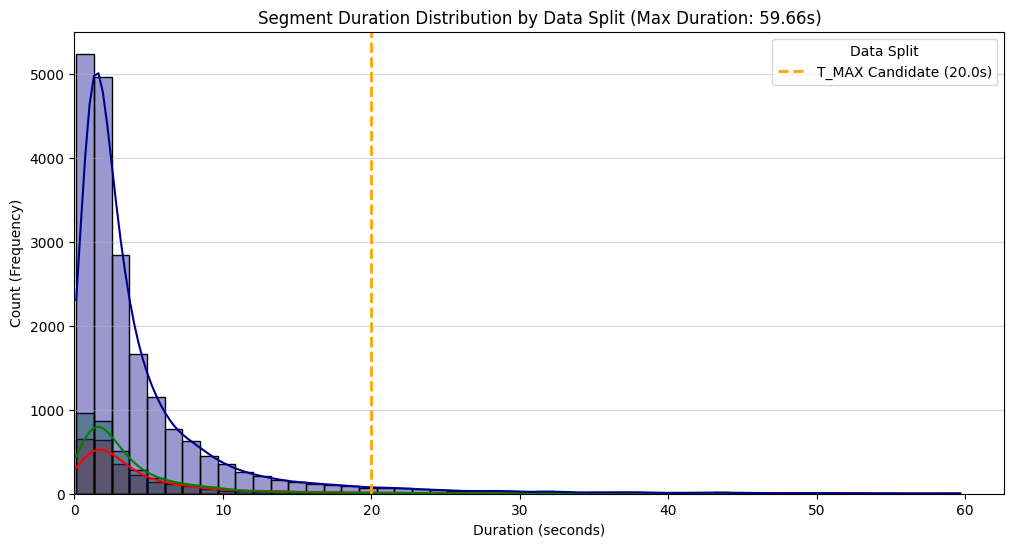

In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from collections import defaultdict

def load_durations_from_jsonl(file_path):
    """Reads a JSONL file (or mock data) and extracts the 'duration'."""
    durations = []
    
    try:
        with open(file_path, 'r') as f:
            for line in f:
                durations.append(json.loads(line.strip())['duration'])
    except FileNotFoundError:
        print(f"File not found: {file_path}. Skipping.")
        pass

    return durations

def plot_duration_distribution(all_durations):
    """Plots the duration distribution for all data splits."""
    
    # Convert dictionary of lists into a single DataFrame for Seaborn
    duration_df = pd.DataFrame({
        'Duration (seconds)': [d for split in all_durations for d in all_durations[split]],
        'Split': [split for split in all_durations for _ in all_durations[split]]
    })
    
    # Calculate the maximum duration found across all splits
    max_duration = duration_df['Duration (seconds)'].max()
    
    print(f"Maximum segment duration across all splits: {max_duration:.2f} seconds")
    
    # remove this max duration if it's an outlier
    if max_duration > 800:  # arbitrary threshold for outlier
        duration_df = duration_df[duration_df['Duration (seconds)'] < 60]
        max_duration = duration_df['Duration (seconds)'].max()
        print(f"Adjusted maximum segment duration (excluding outliers): {max_duration:.2f} seconds")
        
    # Plotting the distribution
    plt.figure(figsize=(12, 6))
    
    # Use a histogram with KDE (Kernel Density Estimate) for visualization
    sns.histplot(
        data=duration_df, 
        x='Duration (seconds)', 
        hue='Split', 
        kde=True, 
        bins=50, 
        palette={'train': 'darkblue', 'val': 'green', 'test': 'red'},
        alpha=0.4
    )
    
    # Draw a line showing the location of the proposed maximum T_max (e.g., 10 seconds)
    # This visually indicates where truncation would occur.
    T_MAX_CANDIDATE = 20.0
    # also display the number of durations captured below this threshold
    count_below_tmax = (duration_df['Duration (seconds)'] <= T_MAX_CANDIDATE).sum()
    total_count = len(duration_df)
    print(f"Number of segments with duration <= {T_MAX_CANDIDATE}s: {count_below_tmax} out of {total_count} ({(count_below_tmax/total_count)*100:.2f}%)")
    plt.axvline(T_MAX_CANDIDATE, color='orange', linestyle='--', linewidth=2, label=f'T_MAX Candidate ({T_MAX_CANDIDATE}s)')
    
    plt.title(f'Segment Duration Distribution by Data Split (Max Duration: {max_duration:.2f}s)')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count (Frequency)')
    plt.xlim(0, max_duration * 1.05)
    plt.legend(title='Data Split')
    plt.grid(axis='y', alpha=0.5)
    
    # Display the plot
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    segment_paths = {
        'train': '/home/nele_pauline_suffo/ProcessedData/audio_cls_input/train_segments.jsonl', 
        'val': '/home/nele_pauline_suffo/ProcessedData/audio_cls_input/val_segments.jsonl',
        'test': '/home/nele_pauline_suffo/ProcessedData/audio_cls_input/test_segments.jsonl'
    }

    all_durations = {}
    for split_name, jsonl_path in segment_paths.items():
        all_durations[split_name] = load_durations_from_jsonl(jsonl_path)
        print(f"Loaded {len(all_durations[split_name]):,} durations for {split_name}.")

    # Generate and display the plot
    plot_duration_distribution(all_durations)